### Using Permutation Importance to determine relevant features and K-Nearest Neighbors to create decision boundaries

Evaluating donors dataset using sklearn's support vector machine, gridsearchcv, amd permutation importance, k-neaest neigbors, and a scatterplot of the target variable "AdustedDonors" in relation to Average Temperature and the consumer price index.

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
pd.set_option("display.max_rows", 10)

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
import warnings

In [95]:
file_path = r'C:\Users\ibaca\DonorByMonth.csv'
df = pd.read_csv(file_path)

In [96]:
df.head()

,Date,Donors,AvgTemp,CPI,Budget,Sales,NewResidentialConstruction(Thousands),HousingUnitPermits(Thousands),HousingUnits,Adjusted Sales,AverageContrusctionHoursWorked,NewHomeSales(Thousands),NewHomeSales,AdjustedDonors
0,1/1/2019,34698,35.9,251.712,1292132,1557361,"1,261",87.0,87000,1557361,39.7,49,49000,34698
1,2/1/2019,27533,39.9,252.776,1271468,1432247,"1,287",80.0,80000,1432247,38.6,57,57000,27533
2,3/1/2019,36468,50.2,254.202,1421717,1667795,"1,305",98.2,98200,1667795,39.3,68,68000,36468
3,4/1/2019,32788,57.4,255.548,1348579,1530041,"1,311",116.6,116600,1530041,39.0,64,64000,32788
4,5/1/2019,39674,61.6,256.092,1336206,1589136,"1,347",118.1,118100,1589136,39.1,56,56000,39674


In [171]:
df.describe()

,Donors,AvgTemp,CPI,Budget,Sales,NewResidentialConstruction(Thousands),HousingUnitPermits(Thousands),HousingUnits,Adjusted Sales,AverageContrusctionHoursWorked,NewHomeSales(Thousands),NewHomeSales,AdjustedDonors
count,60.000000,60.000000,60.000000,6.000000e+01,6.000000e+01,60.000000,60.000000,60.000000,6.000000e+01,60.000000,60.000000,60.000000,60.000000
mean,37985.416667,58.518333,276.558967,1.555777e+06,1.547741e+06,1560.583333,120.718333,120718.333333,1.632616e+06,38.995000,59.683333,59683.333333,38340.750000
std,8425.172322,15.901887,19.706264,6.530974e+05,3.132404e+05,184.596793,17.147560,17147.559906,1.275127e+05,0.306663,10.558139,10558.138746,4713.927876
min,0.000000,35.500000,251.712000,9.985300e+05,0.000000e+00,1066.000000,80.000000,80000.000000,1.331908e+06,38.100000,41.000000,41000.000000,27533.000000
25%,34810.500000,41.800000,257.927500,1.196114e+06,1.519848e+06,1449.000000,112.725000,112725.000000,1.554540e+06,38.875000,52.000000,52000.000000,35148.000000
50%,38409.000000,57.750000,272.349500,1.271406e+06,1.590238e+06,1533.000000,118.450000,118450.000000,1.598242e+06,39.000000,58.000000,58000.000000,38115.000000
75%,40936.500000,73.425000,296.799750,1.399998e+06,1.719001e+06,1714.250000,132.850000,132850.000000,1.728588e+06,39.100000,65.250000,65250.000000,40868.250000
max,65201.000000,85.600000,307.789000,3.080929e+06,1.905336e+06,1915.000000,164.300000,164300.000000,1.905336e+06,39.800000,85.000000,85000.000000,49886.000000


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date                                   60 non-null     object 
 1   Donors                                 60 non-null     int64  
 2   AvgTemp                                60 non-null     float64
 3   CPI                                    60 non-null     float64
 4   Budget                                 60 non-null     int64  
 5   Sales                                  60 non-null     int64  
 6   NewResidentialConstruction(Thousands)  60 non-null     object 
 7   HousingUnitPermits(Thousands)          60 non-null     float64
 8   HousingUnits                           60 non-null     int64  
 9   Adjusted Sales                         60 non-null     int64  
 10  AverageContrusctionHoursWorked         60 non-null     float64
 11  NewHomeS

In [98]:
df = df.drop(columns=['Date'])
df['NewResidentialConstruction(Thousands)'] = df['NewResidentialConstruction(Thousands)'].str.replace(',', '').astype(float)

In [99]:


# ACreate 2 dataframes, one for target and one for features
X = df.drop(columns=['AdjustedDonors'])
y = df['AdjustedDonors']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5],
    'shrinking': [True, False],
    'probability': [True, False]
}

# Initialize the SVM model
svm = SVC()

# Set up the grid search with KFold cross-validation
kf = KFold(n_splits=3)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=kf)

# Fit the grid search to the data
grid_search.fit(X_scaled, y)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Calculate permutation importance
results = permutation_importance(grid_search.best_estimator_, X_scaled, y, scoring='accuracy')

# Create a DataFrame for permutation importance results
perm_importance_df = pd.DataFrame({
    'Feature': df.drop(columns=['AdjustedDonors']).columns,
    'Importance': results.importances_mean
})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

# Display the most influential attributes
print(perm_importance_df.head(10))

Best parameters found:  {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'probability': True, 'shrinking': True}
Best accuracy score:  0.0
                                 Feature  Importance
8                         Adjusted Sales    0.173333
1                                AvgTemp    0.156667
5  NewResidentialConstruction(Thousands)    0.136667
0                                 Donors    0.130000
9         AverageContrusctionHoursWorked    0.126667
2                                    CPI    0.106667
6          HousingUnitPermits(Thousands)    0.103333
7                           HousingUnits    0.103333
3                                 Budget    0.090000
4                                  Sales    0.080000


NOTE on Feature Importance:

T results showhe relative importance of each feature in the modelr**s: 0.073333
Key Observations:
AvgTemp and Adjusted Sales are the most influential features, indicating that they have the highest impact on the model's predictions.
The low accuracy score suggests that the model might not be capturing the underlying patterns in the da**ta differently.

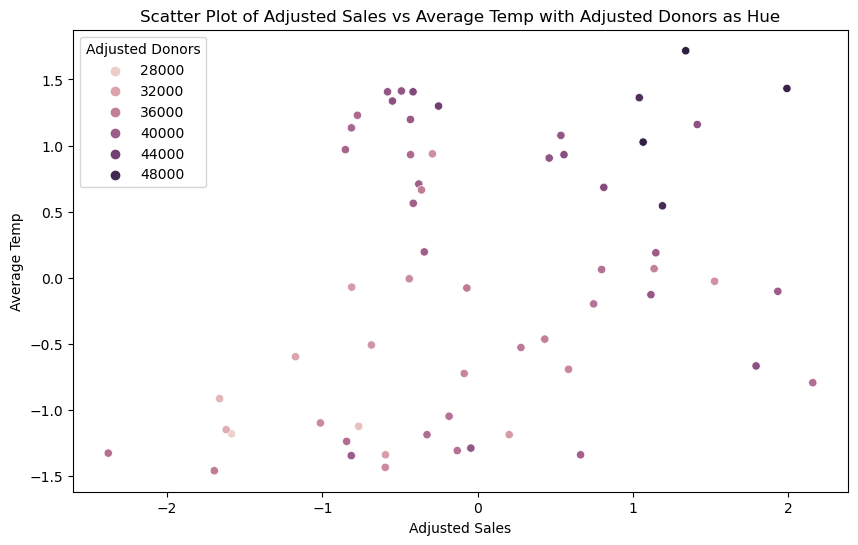

In [100]:
##Plotting the Scaled Data Using the Two Most Impactful Features Above
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df['AdjustedDonors'] = y.values

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=scaled_df, x='Adjusted Sales', y='AvgTemp', hue='AdjustedDonors')
plt.title('Scatter Plot of Adjusted Sales vs Average Temp with Adjusted Donors as Hue')
plt.xlabel('Adjusted Sales')
plt.ylabel('Average Temp')
plt.legend(title='Adjusted Donors')
plt.show()

**Creating a K Neighbors Classifier To Create Decision Boundaries**

In [201]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 5)

In [202]:
model.fit(df[['CPI', 'AvgTemp']], df['AdjustedDonors'])

KNeighborsClassifier()

In [203]:
model.predict([[210,75]])

C:\Users\ibaca\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([38280], dtype=int64)

C:\Users\ibaca\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ibaca\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


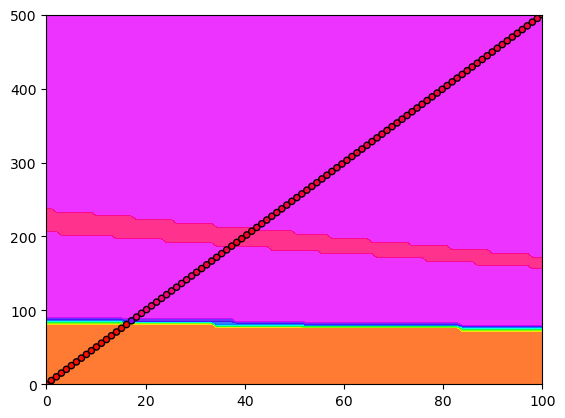

In [204]:
from matplotlib.colors import ListedColormap
import seaborn as sns

def plot_decision_boundary(model, x, y):
    """This function plots the model's decision boundaries over the x and y values provided for multi-class data."""
    # Generate a colormap with enough colors for all classes
    num_classes = len(np.unique(y))
    sns_cmap = ListedColormap(sns.color_palette("hsv", num_classes))

    # Create a meshgrid
    xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100))

    # Predict class labels for each point in the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, cmap=sns_cmap, alpha=0.8)
    plt.scatter(x, y, c=model.predict(np.c_[x, y]), cmap=sns_cmap, edgecolor='k', s=20)
    plt.show()

# Example usage
x_range = np.linspace(0, 100, 100)
y_range = np.linspace(0, 500, 100)
plot_decision_boundary(model, x_range, y_range)

C:\Users\ibaca\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\ibaca\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


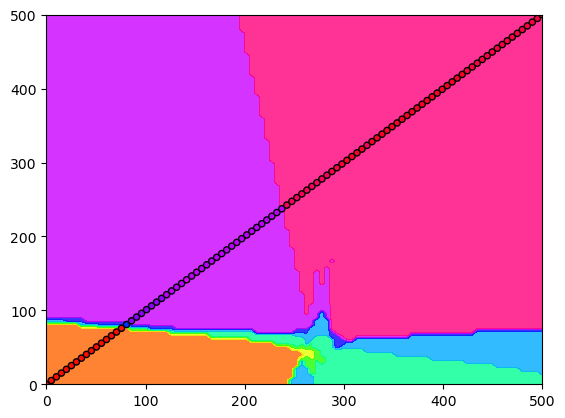

In [205]:

x_range = np.linspace(0, 500, 100)
y_range = np.linspace(0, 500, 100)
plot_decision_boundary(model, x_range, y_range)

In [206]:
#Here we add a column of all our predictions to the dataframe
df["y_hat"] = model.predict(df[["CPI", "AvgTemp"]])

In [207]:
df.head()

,Donors,AvgTemp,CPI,Budget,Sales,NewResidentialConstruction(Thousands),HousingUnitPermits(Thousands),HousingUnits,Adjusted Sales,AverageContrusctionHoursWorked,NewHomeSales(Thousands),NewHomeSales,AdjustedDonors,y_hat
0,34698,35.9,251.712,1292132,1557361,1261.0,87.0,87000,1557361,39.7,49,49000,34698,27533
1,27533,39.9,252.776,1271468,1432247,1287.0,80.0,80000,1432247,38.6,57,57000,27533,27533
2,36468,50.2,254.202,1421717,1667795,1305.0,98.2,98200,1667795,39.3,68,68000,36468,30216
3,32788,57.4,255.548,1348579,1530041,1311.0,116.6,116600,1530041,39.0,64,64000,32788,32788
4,39674,61.6,256.092,1336206,1589136,1347.0,118.1,118100,1589136,39.1,56,56000,39674,32788


In [208]:

from sklearn.metrics import accuracy_score
##Function that calculates the misclassification rate for the k-nearest neighbors classifier using different k's
def get_misclassification_rate_for_k(k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(df[['AvgTemp', 'CPI']], df['AdjustedDonors'])
    predictions = model.predict(df[['AvgTemp', 'CPI']])
    accuracy = accuracy_score(df['AdjustedDonors'], predictions)
    misclassification_rate = 1 - accuracy
    print(f"Misclassification rate for k={k}: {misclassification_rate}")
    return misclassification_rate

In [209]:
##Here, we want to see the missclassification rates for various values of k, in this case k=1 through k=25 
ks = range(1, 25)
errors = [get_misclassification_rate_for_k(k) for k in ks]
errors_and_ks = pd.DataFrame({'k': ks, 'Misclassification Rate': errors})

Misclassification rate for k=1: 0.0
Misclassification rate for k=2: 0.5333333333333333
Misclassification rate for k=3: 0.6833333333333333
Misclassification rate for k=4: 0.75
Misclassification rate for k=5: 0.8166666666666667
Misclassification rate for k=6: 0.8333333333333334
Misclassification rate for k=7: 0.8666666666666667
Misclassification rate for k=8: 0.9333333333333333
Misclassification rate for k=9: 0.9333333333333333
Misclassification rate for k=10: 0.95
Misclassification rate for k=11: 0.9833333333333333
Misclassification rate for k=12: 0.9833333333333333
Misclassification rate for k=13: 0.9833333333333333
Misclassification rate for k=14: 0.9833333333333333
Misclassification rate for k=15: 0.9833333333333333
Misclassification rate for k=16: 0.9833333333333333
Misclassification rate for k=17: 0.9833333333333333
Misclassification rate for k=18: 0.9833333333333333
Misclassification rate for k=19: 0.9833333333333333
Misclassification rate for k=20: 0.9833333333333333
Misclassific

### Interpretation
For ( k=1 ): The misclassification rate is 0.0, meaning the model perfectly classifies all the data points. This is often a sign of overfitting, where the model is too closely fitted to the training data and may not generalize well to new data.

For ( k=2 ) to ( k=10 ): The misclassification rate increases significantly, indicating that the model's performance deteriorates as ( k ) increases. This suggests that the model is not able to capture the underlying patterns in the data as effectively with these values of ( k ).

For ( k=11 ) to ( k=24 ): The misclassification rate stabilizes at around 0.9833, indicating that the model is consistently misclassifying a large portion of the data. This high misclassification rate suggests that the model is underfitting, meaning it is too simple to capture the complexity of the data.###

In [210]:
errors_and_ks["-k"] = -errors_and_ks["k"]
errors_and_ks

,k,Misclassification Rate,-k
0,1,0.000000,-1
1,2,0.533333,-2
2,3,0.683333,-3
3,4,0.750000,-4
4,5,0.816667,-5
...,...,...,...
19,20,0.983333,-20
20,21,0.983333,-21
21,22,0.983333,-22
22,23,0.983333,-23


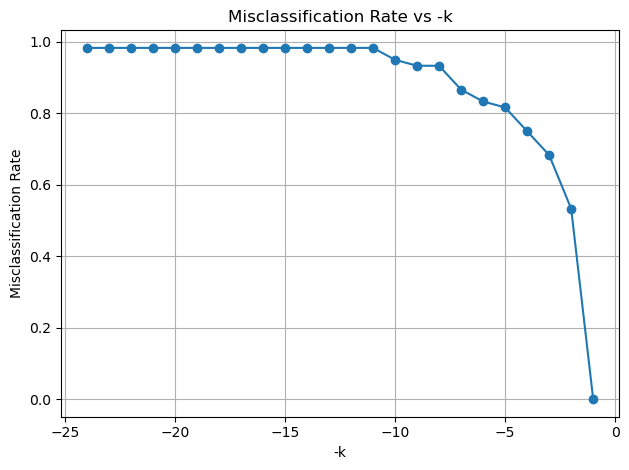

<Figure size 640x480 with 0 Axes>

In [211]:
import matplotlib.pyplot as plt

def standardize_figure(ax):
    ax.grid(True)
    plt.tight_layout()

# Plotting Misclassification Rate vs k
fig, ax = plt.subplots()
ax.plot(errors_and_ks['k'], errors_and_ks['Misclassification Rate'], marker='o')
ax.set_xlabel('k')
ax.set_ylabel('Misclassification Rate')
ax.set_title('Misclassification Rate vs k')
standardize_figure(ax)
plt.savefig('misclassification_rate_vs_k.png', dpi=200)
plt.close(fig)

# Plotting Misclassification Rate vs -k
fig, ax = plt.subplots()
ax.plot(errors_and_ks['-k'], errors_and_ks['Misclassification Rate'], marker='o')
ax.set_xlabel('-k')
ax.set_ylabel('Misclassification Rate')
ax.set_title('Misclassification Rate vs -k')
standardize_figure(ax)
plt.show()
plt.savefig('misclassification_rate_vs_neg_k.png', dpi=200)
plt.close(fig)


In [212]:

model = KNeighborsClassifier()
parameters_to_try = {'n_neighbors': np.arange(1, 20)}

from sklearn.model_selection import GridSearchCV
model_finder = GridSearchCV(estimator = model, 
                               param_grid = parameters_to_try, 
                               scoring = "accuracy",
                               cv = 2)

In [213]:
model_finder.fit(df[['AvgTemp', 'CPI']], df["AdjustedDonors"])

C:\Users\ibaca\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='accuracy')

In [214]:
model_finder.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [215]:
model_finder.cv_results_['mean_test_score']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [217]:
print(len(model_finder.cv_results_['mean_test_score']))
print(len(np.array(range(1, len(df)))))

19
59


In [218]:
gridsearch_output = pd.DataFrame({'CV accuracy': model_finder.cv_results_['mean_test_score'],
             'k': np.array(range(1, 20))})

In [220]:
gridsearch_output["-k"] = -gridsearch_output["k"]
gridsearch_output["CV Error"] = 1 - gridsearch_output["CV accuracy"]

In [222]:
gridsearch_output

,CV accuracy,k,-k,CV Error
0,0.0,1,-1,1.0
1,0.0,2,-2,1.0
2,0.0,3,-3,1.0
3,0.0,4,-4,1.0
4,0.0,5,-5,1.0
...,...,...,...,...
14,0.0,15,-15,1.0
15,0.0,16,-16,1.0
16,0.0,17,-17,1.0
17,0.0,18,-18,1.0


In [223]:
both_training_and_CV_errors = pd.merge(errors_and_ks.rename(columns = {"Misclassification Rate": "Training Error"}),
         gridsearch_output,
         left_on = "-k",
         right_on = "-k",
         how = "inner")
both_training_and_CV_errors

,k_x,Training Error,-k,CV accuracy,k_y,CV Error
0,1,0.000000,-1,0.0,1,1.0
1,2,0.533333,-2,0.0,2,1.0
2,3,0.683333,-3,0.0,3,1.0
3,4,0.750000,-4,0.0,4,1.0
4,5,0.816667,-5,0.0,5,1.0
...,...,...,...,...,...,...
14,15,0.983333,-15,0.0,15,1.0
15,16,0.983333,-16,0.0,16,1.0
16,17,0.983333,-17,0.0,17,1.0
17,18,0.983333,-18,0.0,18,1.0


In [224]:
both_training_and_CV_errors["CV Error"]

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
Name: CV Error, Length: 19, dtype: float64

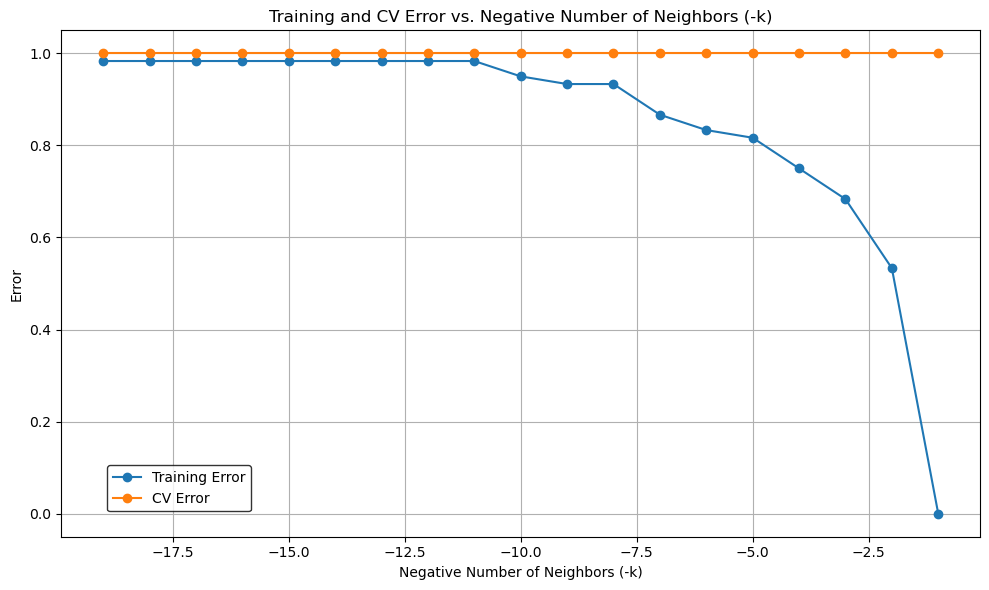

In [225]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(both_training_and_CV_errors['-k'], both_training_and_CV_errors['Training Error'], marker='o', label='Training Error')
ax.plot(both_training_and_CV_errors['-k'], both_training_and_CV_errors['CV Error'], marker='o', label='CV Error')

# Customize the plot
ax.set_title('Training and CV Error vs. Negative Number of Neighbors (-k)')
ax.set_xlabel('Negative Number of Neighbors (-k)')
ax.set_ylabel('Error')
ax.grid(True)
ax.legend(title='', loc='lower left', bbox_to_anchor=(0.05, 0.05), borderaxespad=0., edgecolor='black', frameon=True)

# Show the plot
plt.tight_layout()
plt.show()